In [ ]:
# This notebook trains & benchmarks flows on a multivariate gaussian problem.
# See flows.py for a library of modules.

In [34]:
# This cell initializes a multivariate normal problem, with large means and covariance
import torch
from torch.distributions import *
from flows import *

# - See kl-estimator.ipynb for details & benchmark
def kl_estimate_log(log_px, log_qx, n):
    return (log_px - log_qx).mean()

# dataset is skewed, correlated multivariate gaussian
dim = 2
datapoints = 2500

mu = torch.tensor([4.5, -4.5])
sigma = torch.tensor([[3.0, 2], [2, 3.0]])
dist = MultivariateNormal(mu, sigma)

table = dist.sample_n(datapoints)
dataset = torch.utils.data.TensorDataset(table)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1000)
print(table)

tensor([[ 5.2058, -2.8610],
        [ 4.9605, -2.4179],
        [ 0.5278, -6.0876],
        ...,
        [ 3.4505, -5.8133],
        [ 7.1859, -1.3892],
        [ 5.3586, -4.7540]])


In [49]:
# This cell introduces a multivariate gaussian mixture problem, where the means and covariance of each gaussian are taken from the uniform distribution
dim = 2
m = 4
datapoints = 2500

from torch.distributions import MixtureSameFamily

mix = Categorical(torch.ones(m,))
comp = Independent(Normal(
             torch.randn(m,2), torch.rand(m,2)), 1)
dist = MixtureSameFamily(mix, comp)

table = dist.sample_n(datapoints)
dataset = torch.utils.data.TensorDataset(table)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1000)

In [50]:
# flows convert to normal dist
normal_flows = Flows(
    DenseTriangularFlow(dim, True),
    DenseTriangularFlow(dim, False),
    DenseTriangularFlow(dim, True),
    DenseTriangularFlow(dim, False),
    SoftsquareFlow(dim),
    DenseTriangularFlow(dim, True),
    DenseTriangularFlow(dim, False),
    DenseTriangularFlow(dim, True),
    DenseTriangularFlow(dim, False),
    SoftsquareFlow(dim),
    DenseTriangularFlow(dim, True),
    DenseTriangularFlow(dim, False),
    DenseTriangularFlow(dim, True),
    DenseTriangularFlow(dim, False),
    SoftsquareFlow(dim),
)

# final flow converts to normal

# train on NLL
net = FlowModule(normal_flows, NegLogLikelihoodLoss(dim))

optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

In [51]:
final_loss = 0.0
for batch in range(200):  #1oop over the dataset multiple times
    for _, data in enumerate(dataloader, 0):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        loss = net(data[0])
        loss.backward()
        optimizer.step()
        final_loss = loss
print("final loss: %.03f" % final_loss)

final loss: 1.535


In [52]:
for f in normal_flows.flows:
    print(f)
    for name, param in f.named_parameters():
        print("  %s = %s" % (name, param.data))
    print()

DenseTriangularFlow()
  w = tensor([[ 0.8021, -0.3231],
        [ 0.0000,  0.7140]])
  b = tensor([-0.2840, -0.3747])

DenseTriangularFlow()
  w = tensor([[ 0.8391,  0.0000],
        [-0.1706,  0.8399]])
  b = tensor([-0.3098, -0.3785])

DenseTriangularFlow()
  w = tensor([[ 0.9198, -0.0860],
        [ 0.0000,  0.9550]])
  b = tensor([-0.3158, -0.3738])

DenseTriangularFlow()
  w = tensor([[ 0.9626,  0.0000],
        [-0.0735,  1.0113]])
  b = tensor([-0.3257, -0.3750])

SoftsquareFlow()
  a = tensor([0.8615, 0.9935])
  b = tensor([0.2858, 0.3324])

DenseTriangularFlow()
  w = tensor([[0.9331, 0.1571],
        [0.0000, 0.9357]])
  b = tensor([0.4738, 0.1209])

DenseTriangularFlow()
  w = tensor([[ 0.9949,  0.0000],
        [-0.2543,  0.9415]])
  b = tensor([0.4244, 0.1234])

DenseTriangularFlow()
  w = tensor([[1.0731, 0.2522],
        [0.0000, 0.9350]])
  b = tensor([0.4184, 0.0261])

DenseTriangularFlow()
  w = tensor([[ 1.1002,  0.0000],
        [-0.5146,  0.9354]])
  b = tensor([0.

In [57]:
# Estimate the KL divergence between the source distribution, and the transformed data (under the change of variables, so we add log_det)
n = 50000
points = dist.sample_n(n)
p_points = dist.log_prob(points)

normalized_points, log_det = normal_flows(points)
dist_target = MultivariateNormal(torch.zeros(dim), torch.eye(dim))
p_normalized_points = dist_target.log_prob(normalized_points) + log_det

uniform_with_y = torch.stack([p_points.exp(), p_normalized_points.exp()], dim=1)
print(uniform_with_y)

print()

print("~kl div:", kl_estimate_log(p_points, p_normalized_points, n))

tensor([[0.0178, 0.0375],
        [0.0805, 0.2719],
        [0.8604, 0.5097],
        ...,
        [0.6369, 0.5028],
        [0.1432, 0.2213],
        [0.2772, 0.4366]], grad_fn=<StackBackward>)

~kl div: tensor(0.1322, grad_fn=<MeanBackward0>)


In [58]:
# Run the KL divergence estimate at each layer in the network
n = 5000
points = dist.sample_n(n)
p_points = dist.log_prob(points)

for ps, log_det, f in zip(*normal_flows.forward_trace(points),normal_flows.flows):
    dist_target = MultivariateNormal(torch.zeros(dim), torch.eye(dim))
    p_normalized_points = dist_target.log_prob(ps) + log_det
    approx_kl_divergence = kl_estimate_log(p_points, p_normalized_points, n).item()
    params = list(f.parameters())
    print("%1.4f - %s:" % (approx_kl_divergence, f))

1.6814 - DenseTriangularFlow():
2.2109 - DenseTriangularFlow():
2.7798 - DenseTriangularFlow():
3.5297 - DenseTriangularFlow():
5.0690 - SoftsquareFlow():
4.1412 - DenseTriangularFlow():
2.9519 - DenseTriangularFlow():
2.5984 - DenseTriangularFlow():
2.0567 - DenseTriangularFlow():
2.9058 - SoftsquareFlow():
1.6021 - DenseTriangularFlow():
0.8328 - DenseTriangularFlow():
0.4196 - DenseTriangularFlow():
0.2112 - DenseTriangularFlow():
0.1391 - SoftsquareFlow():


In [75]:
import numpy
import seaborn
import matplotlib.pylab
import pandas

def jointplot_2d(data):
    xs = pandas.DataFrame(data[0:3000, 0:1].detach().numpy(), columns = ['X'])
    ys = pandas.DataFrame(data[0:3000, 1:2].detach().numpy(), columns = ['Y'])

    seaborn.jointplot(xs, ys, kind="hex", color="#4CB391")

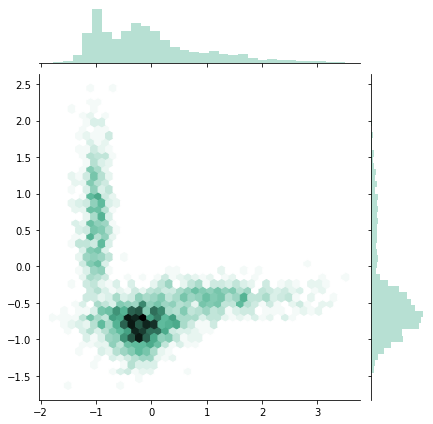

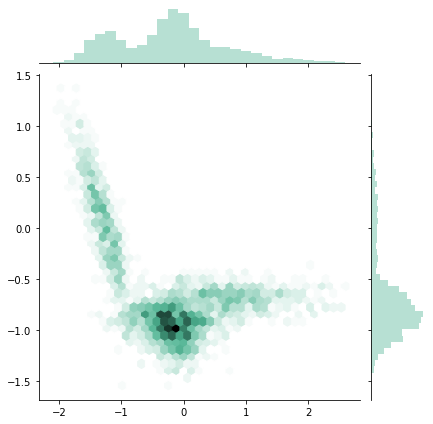

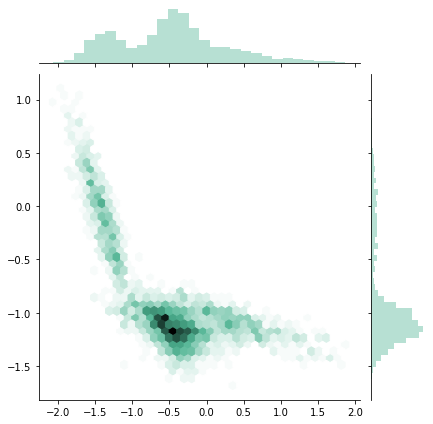

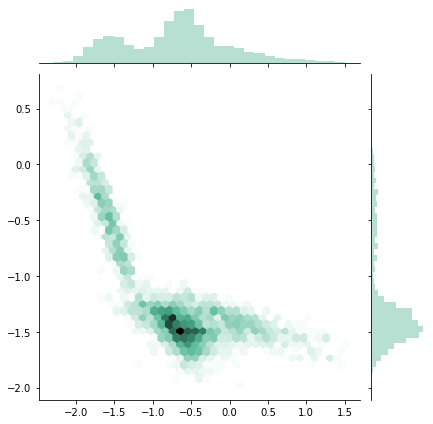

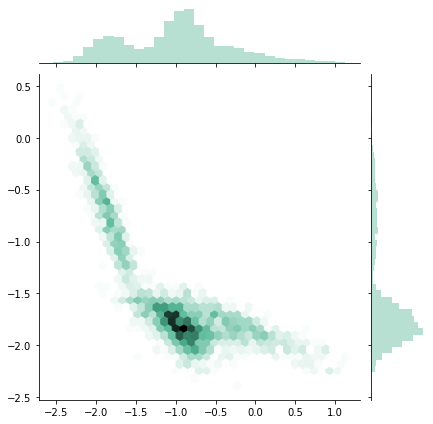

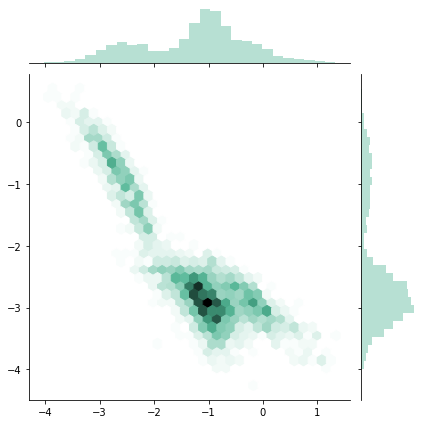

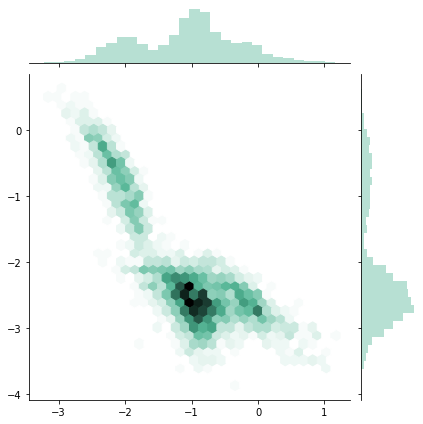

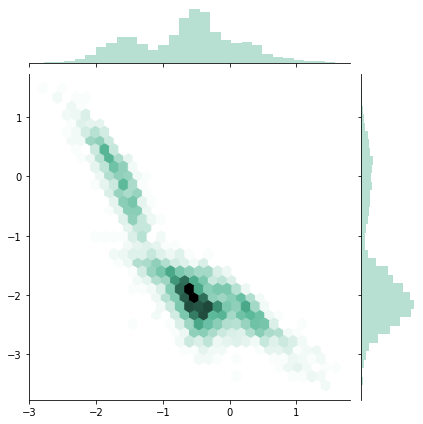

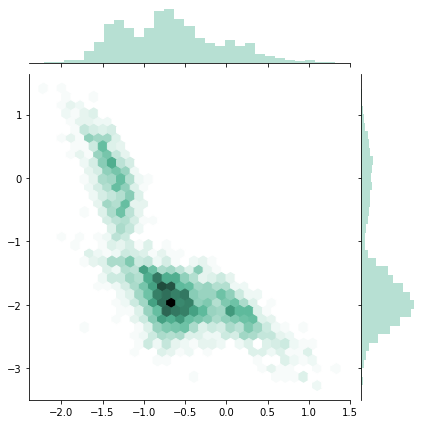

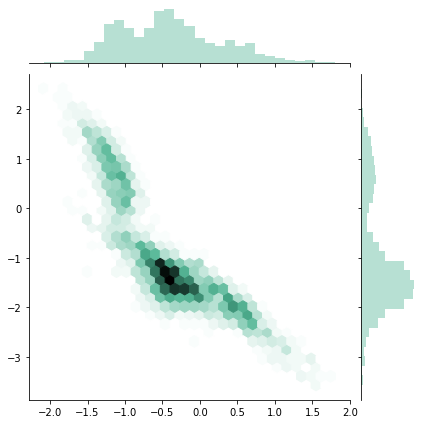

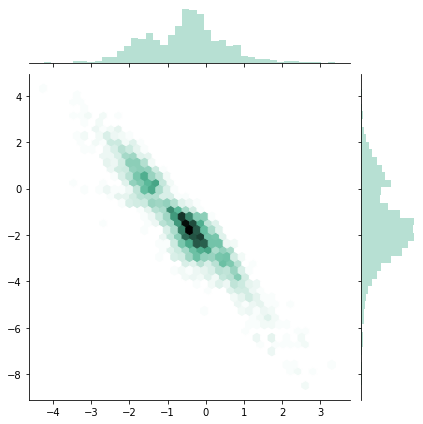

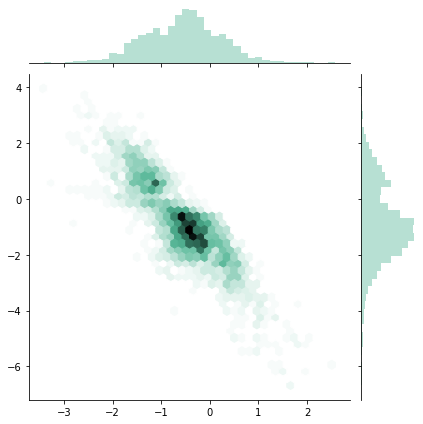

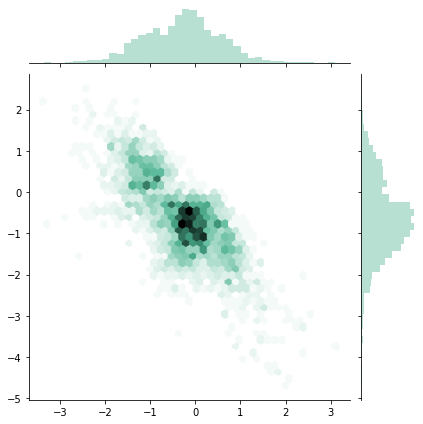

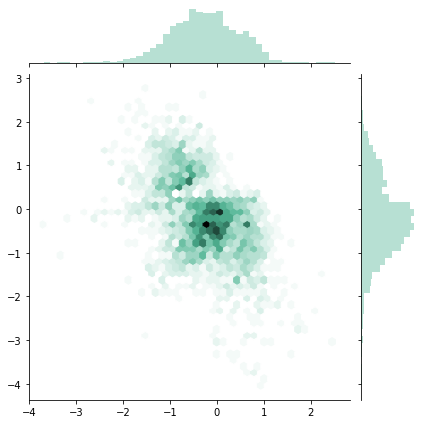

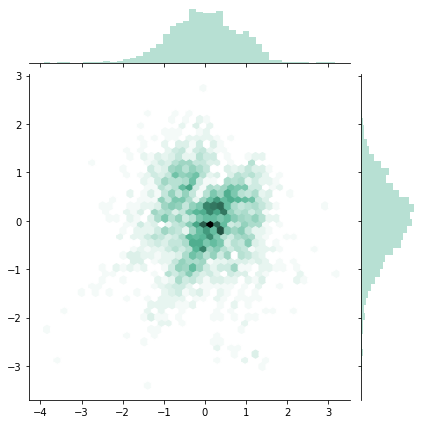

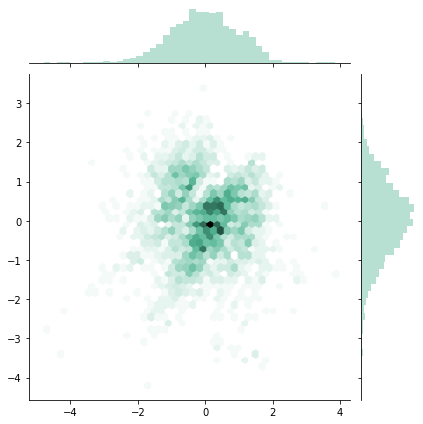

In [76]:
# A series of trace plots from the gaussian mixture problem
jointplot_2d(table)
for ps, log_dest, f in zip(*normal_flows.forward_trace(table),normal_flows.flows):
    jointplot_2d(ps)